# Final Project

**From bCourses** 

Final Project Rubric
Your slides should include:

Title, Authors  
(15%) Motivation: Introduce your question and why the question is interesting. Explain what has been done before in this space. Describe your overall plan to approach your question. Provide a summary of your results.  

(15%) Data: Describe in detail the data you are using, including the source(s) of the data and relevant statistics.  

(15%) Modeling: Describe in detail the models (baseline + improvement over baseline) that you use in your approach.  

(30%) Experiments: Provide insight into the effect of different hyperperameter choices. Please include tables, figures, graphs to illustrate your experiments.  

(10%) Conclusions: Summarize the key results, what has been learned, and avenues for future work.  

(15%) Code submission: Provide link to your team's GitHub repo. The code should be well commented and organized.  

Contributions: Specify the contributions of each author (e.g., data processing, algorithm implementation, slides, etc.). Note that the final project grade is individual, based on each member's contribution and team size.

**From Github - Spring 2024**  

Project Submission Guidelines and Grading
In your presentation include a slide that lists the contribution of each team member – e.g, X did data processing, Y implemented component linear regression experiments, etc  
.
In your presentation include a slide with references (i.e. cite any outside code/materials use  
d)
In your presentation include a slide answering all the questions from the NeurIPS checkl.

https://neurips.cc/Conferences/2021/PaperInformation/PaperChecklistst.

## Motivation

## Data

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import datetime

In [26]:
df = pd.read_csv('GOOGLE.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044


In [27]:
df.shape

(4717, 6)

In [28]:
df['Date'] = pd.to_datetime(df['Date'])

#first and last date
first_date = df['Date'].min().date()
last_date = df['Date'].max().date()

# Calculate time differences
time_difference_days = (last_date - first_date).days
time_difference_years = time_difference_days / 365 


print("First Date:", first_date)
print("Last Date:", last_date)
print("Date Difference (Years)", round(time_difference_years,1))

First Date: 2004-08-19
Last Date: 2023-05-15
Date Difference (Years) 18.7


Check for null values

In [29]:
null_counts = df.isnull().sum()
null_counts

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Check differences on price. High - low, open -close, etc

In [30]:
df['open-close'] = df['Open'] - df['Close']
df['open-high'] = df['Open']-df['High']
df['open-low'] = df['Open'] - df['Low']
df['close-high'] = df['Close']-df['High']
df['close-low'] = df['Close'] - df['Low']
df['high-low'] = df['High'] - df['Low']

df.head()

,Date,Open,High,Low,Close,Volume,open-close,open-high,open-low,close-high,close-low,high-low
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924,-0.008508,-0.101601,0.101102,-0.093093,0.109610,0.202703
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856,-0.182682,-0.201952,0.012763,-0.019270,0.195445,0.214715
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512,0.033784,-0.068318,0.042543,-0.102102,0.008759,0.110861
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748,0.159410,-0.009009,0.191942,-0.168419,0.032532,0.200951
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044,-0.026026,-0.076076,0.027027,-0.050050,0.053053,0.103103


Count positive and negative values in "open-close"

In [31]:
positive_count = (df['open-close'] > 0).sum()
negative_count = (df['open-close'] < 0).sum()


counts_df = pd.DataFrame({'Count': [positive_count, negative_count]}, index=['Positive', 'Negative'])


counts_df


,Count
Positive,2353
Negative,2358


we need to add more data exploration...

## Modeling

the baseline could be: the mean from the past 3 days..

In [32]:
#only date and close price
df = df[['Date', "Close"]]
df["Date"][0]

Timestamp('2004-08-19 00:00:00')

In [33]:
#data are strings we need to convert to date

import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
datetime_object  = str_to_datetime('2004-08-25')
datetime_object

datetime.datetime(2004, 8, 25, 0, 0)

In [34]:
#make date our index
# with command we will make date our index number 
df.index = df.pop('Date')

<Axes: xlabel='Date'>

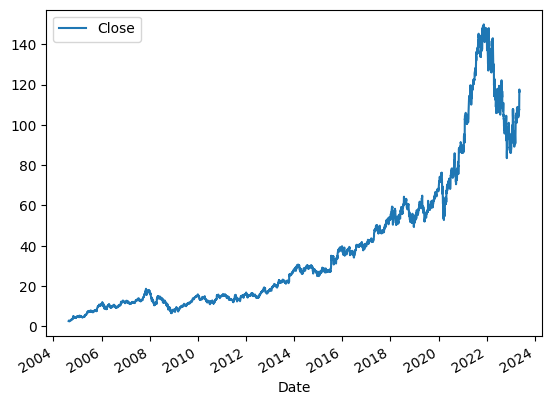

In [35]:
df.plot()

Lets define a function to set date windows 

In [36]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Feature-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

#this function was obtained in https://github.com/bilalwsr

lets get an example window 

In [37]:
#Lets set it to 5 days
windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=5)
windowed_df.head()

,Target Date,Feature-5,Feature-4,Feature-3,Feature-2,Feature-1,Target
0,2021-03-25,101.067001,101.348000,101.534500,102.066498,101.626503,101.623001
1,2021-03-26,101.348000,101.534500,102.066498,101.626503,101.623001,101.236504
2,2021-03-29,101.534500,102.066498,101.626503,101.623001,101.236504,102.289497
3,2021-03-30,102.066498,101.626503,101.623001,101.236504,102.289497,102.323502
4,2021-03-31,101.626503,101.623001,101.236504,102.289497,102.323502,103.125999


Now we define a function to set the features to X and target to y

In [38]:
def window_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [39]:
dates, X, y = window_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 5, 1), (252,))

#### Train, Validation and Test Split

In [40]:
#define percentage to train up to
# validation will be from training percentage to val_percent
train_percent = 0.8
val_percent = 0.9

train_index = int(len(dates) * train_percent)
val_index = int(len(dates) * val_percent)

In [41]:
#split the data
dates_train, X_train, y_train = dates[:train_index], X[:train_index], y[:train_index]

dates_val, X_val, y_val = dates[train_index:val_index], X[train_index:val_index], y[train_index:val_index]

dates_test, X_test, y_test = dates[val_index:], X[val_index:], y[val_index:]

Lets plot the data

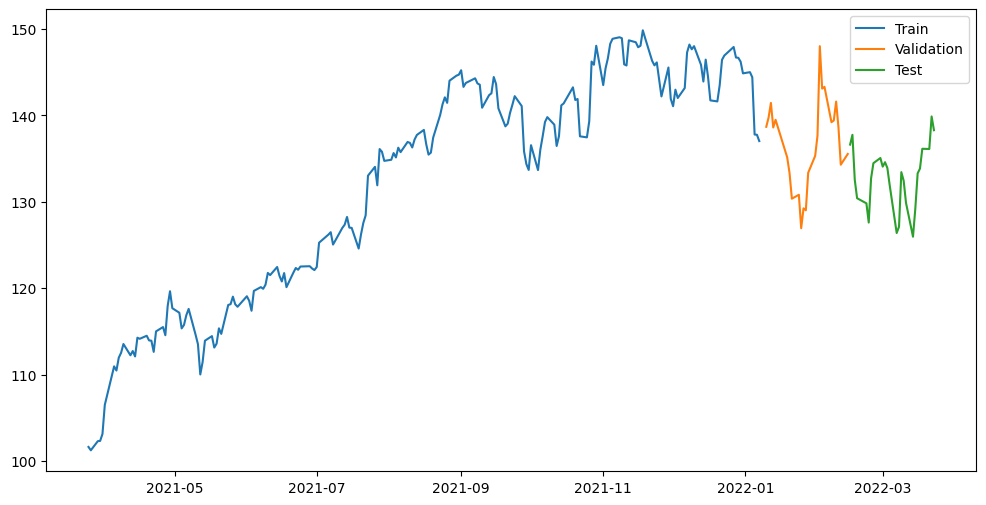

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

Now lets set a baseline. 

The baseline is the mean of the past days on the window

In [43]:
# Calculate the mean as our baseline
baseline_train_prediction = np.mean(X_train, axis=1)

baseline_test_prediction = np.mean(X_test, axis=1)

baseline_val_prediction = np.mean(X_val, axis=1)


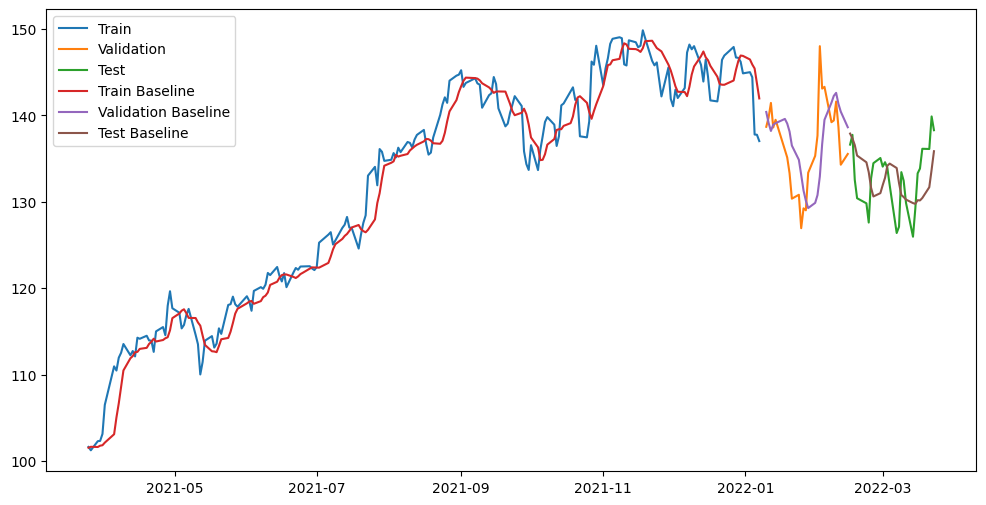

In [44]:
plt.figure(figsize=(12, 6))

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.plot(dates_train, baseline_train_prediction)
plt.plot(dates_val, baseline_val_prediction)
plt.plot(dates_test, baseline_test_prediction)

plt.legend(['Train', 'Validation', 'Test','Train Baseline','Validation Baseline','Test Baseline'])

In [45]:
# Calculate Mean Absolute Error (MAE)
mae_train_base = mean_absolute_error(y_train, baseline_train_prediction)

mae_val_base = mean_absolute_error(y_val, baseline_val_prediction)

mae_test_base = mean_absolute_error(y_test, baseline_test_prediction)

#print("MAE for Train Set:", mae_train)
print("MAE for Validation Set:", mae_val_base)
print("MAE for Test Set:", mae_test_base)


MAE for Validation Set: 3.9188807
MAE for Test Set: 3.2452872


#### LSTM model

Lets try to beat the baseline with a LSTM model

In [46]:
#lets define the model
days = 5
model = Sequential([layers.Input((days, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

Lets fit and print the MAE on the validation set

In [47]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)

final_mae = model.evaluate(X_val, y_val)[1]
print("Final MAE on validation data:", final_mae)



1/1 [==============================] - 0s 34ms/step - loss: 13.4146 - mean_absolute_error: 2.7579
Final MAE on validation data: 2.757944345474243


Now on the test Set

In [48]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Final MAE on test data:", test_mae)

1/1 [==============================] - 0s 33ms/step - loss: 10.1304 - mean_absolute_error: 2.6770
Final MAE on test data: 2.677023410797119


We improved from the basseline

In [49]:
print("Baseline MAE - Validation:", mae_val_base)
print("Baseline MAE - Test:", mae_test_base)
print("LSTM - MAE - Validation:", final_mae)
print("LSTM - MAE - Test:", test_mae)

Baseline MAE - Validation: 3.9188807
Baseline MAE - Test: 3.2452872
LSTM - MAE - Validation: 2.757944345474243
LSTM - MAE - Test: 2.677023410797119


## Experiments

I thought we could try:
- Different Window sizes
- Different layer architecture with LSTM
- Use CNN Layers
- Altought is more Statitics than ML, we could try ARIMA and compare results
- ...

## Conclusions

## Contributions

# Extra

In [54]:
predictions = model.predict(X_val)

1/1 [==============================] - 0s 29ms/step


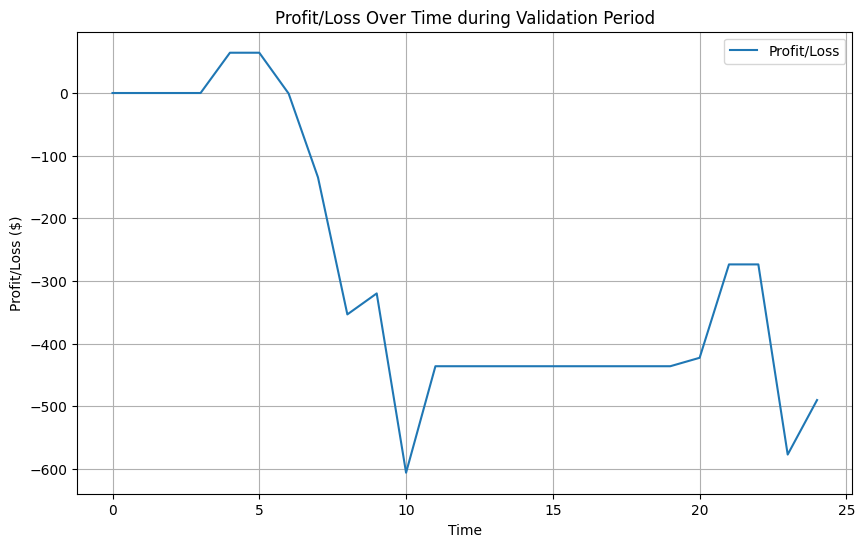

Initial cash: 10000
Final cash: 9509.729400634766
Profit/Loss: -490.2705993652344


In [55]:
import matplotlib.pyplot as plt

# Simulate trading and store profit/loss at each time step
def simulate_trading_with_time(predictions, real_values):
    transactions = []  # Store transactions (buy or sell)
    cash = 10000  # Initial cash
    stocks = 0  # Initial number of stocks owned
    profit_loss_over_time = []  # Store profit/loss at each time step
    
    for i in range(len(predictions)):
        predicted_price = predictions[i]
        real_price = real_values[i]
        
        if predicted_price > real_price:
            # Buy stocks
            if cash > real_price:
                stocks_to_buy = cash // real_price  # Buy as many stocks as possible
                stocks += stocks_to_buy
                cash -= stocks_to_buy * real_price
                transactions.append(('Buy', real_price, stocks_to_buy))
        else:
            # Sell stocks
            if stocks > 0:
                cash += stocks * real_price
                transactions.append(('Sell', real_price, stocks))
                stocks = 0
        
        # Calculate profit/loss at each time step
        profit_loss_over_time.append(cash + (stocks * real_price) - 10000)  # Subtract initial cash
    
    # Calculate final cash and profit/loss
    final_cash = cash + (stocks * real_values[-1])
    initial_cash = 10000
    profit_loss = final_cash - initial_cash
    
    return transactions, profit_loss_over_time, initial_cash, final_cash, profit_loss

# Simulate trading and get profit/loss over time
transactions, profit_loss_over_time, initial_cash, final_cash, profit_loss = simulate_trading_with_time(predictions, y_val)

# Plot profit/loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(profit_loss_over_time)), profit_loss_over_time, label='Profit/Loss')
plt.title('Profit/Loss Over Time during Validation Period')
plt.xlabel('Time')
plt.ylabel('Profit/Loss ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print initial cash, final cash, and profit/loss
print("Initial cash:", initial_cash)
print("Final cash:", final_cash)
print("Profit/Loss:", profit_loss)



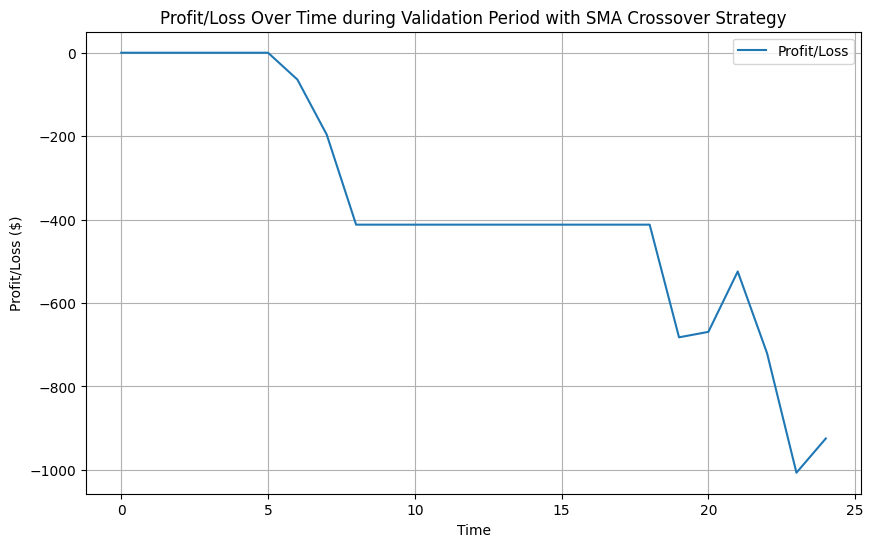

Initial cash: 10000
Final cash: 9075.183639526367
Profit/Loss: -924.8163604736328


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume you have already trained your model and have it stored in the variable 'model'

# Simulate trading and store profit/loss at each time step
def simulate_trading_with_sma(predictions, real_values, short_window=5, long_window=20):
    transactions = []  # Store transactions (buy or sell)
    cash = 10000  # Initial cash
    stocks = 0  # Initial number of stocks owned
    profit_loss_over_time = []  # Store profit/loss at each time step
    
    # Calculate short and long moving averages
    short_sma = pd.Series(predictions).rolling(window=short_window, min_periods=1).mean()
    long_sma = pd.Series(predictions).rolling(window=long_window, min_periods=1).mean()
    
    for i in range(len(predictions)):
        predicted_price = predictions[i]
        real_price = real_values[i]
        short_avg = short_sma[i]
        long_avg = long_sma[i]
        
        # Buy condition: short SMA crosses above long SMA
        if short_avg > long_avg and i > 0 and short_sma[i-1] <= long_sma[i-1]:
            # Buy stocks
            if cash > real_price:
                stocks_to_buy = cash // real_price  # Buy as many stocks as possible
                stocks += stocks_to_buy
                cash -= stocks_to_buy * real_price
                transactions.append(('Buy', real_price, stocks_to_buy))
        
        # Sell condition: short SMA crosses below long SMA
        elif short_avg < long_avg and i > 0 and short_sma[i-1] >= long_sma[i-1]:
            # Sell stocks
            if stocks > 0:
                cash += stocks * real_price
                transactions.append(('Sell', real_price, stocks))
                stocks = 0
                
        # Calculate profit/loss at each time step
        profit_loss_over_time.append(cash + (stocks * real_price) - 10000)  # Subtract initial cash
    
    # Calculate final cash and profit/loss
    final_cash = cash + (stocks * real_values[-1])
    initial_cash = 10000
    profit_loss = final_cash - initial_cash
    
    return transactions, profit_loss_over_time, initial_cash, final_cash, profit_loss

# Simulate trading and get profit/loss over time
transactions, profit_loss_over_time, initial_cash, final_cash, profit_loss = simulate_trading_with_sma(predictions.flatten(), y_val)

# Plot profit/loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(profit_loss_over_time)), profit_loss_over_time, label='Profit/Loss')
plt.title('Profit/Loss Over Time during Validation Period with SMA Crossover Strategy')
plt.xlabel('Time')
plt.ylabel('Profit/Loss ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print initial cash, final cash, and profit/loss
print("Initial cash:", initial_cash)
print("Final cash:", final_cash)
print("Profit/Loss:", profit_loss)
